In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_log_error
from haversine import haversine, Unit
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.impute import IterativeImputer
import xgboost
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

# Data pre-processing

In [174]:
dfTrain = pd.read_csv("prepared_data/apartments_and_building_train.csv")
dfTest = pd.read_csv("prepared_data/apartments_and_building_test.csv")

In [175]:
def get_distance_center(lat1, lon1):
    dist = haversine((lat1, lon1), (55.751244, 37.618423), unit=Unit.METERS)
    return round(dist/1000, 3)

def get_distance_olympic(lat1, lon1):
    dist = haversine((lat1, lon1), (55.71860376378105, 37.554374506870126), unit=Unit.METERS)
    return round(dist/1000, 3)

def get_shortest_distance(lat, lon, coordinates):
    shortest = np.inf
    for coord in coordinates:
        dist = haversine(coord, (lat, lon), unit=Unit.METERS)
        if dist < shortest:
            shortest = dist
    if shortest == np.inf:
        return 100
    return round(shortest/1000, 3)

Distance to center

In [176]:
dfTrain["distance_center"] = dfTrain.loc[:, "latitude":"longitude"].apply(lambda x: get_distance_center(x.latitude, x.longitude), axis=1)
dfTest["distance_center"] = dfTest.loc[:, "latitude":"longitude"].apply(lambda x: get_distance_center(x.latitude, x.longitude), axis=1)

dfTrain["distance_olympic"] = dfTrain.loc[:, "latitude":"longitude"].apply(lambda x: get_distance_olympic(x.latitude, x.longitude), axis=1)
dfTest["distance_olympic"] = dfTest.loc[:, "latitude":"longitude"].apply(lambda x: get_distance_olympic(x.latitude, x.longitude), axis=1)

Other distance features

In [177]:
def keep_every_x_coord(coordinates, x):
    return coordinates[0::x]

def add_distance_to(target, df_train, df_test):
    targets = pd.read_csv(f"prepared_data/extra_features/{target}.csv")
    coordinates = list(zip(targets["latitude"], targets["longitude"]))

    if target == "highway":
        coordinates = keep_every_x_coord(coordinates, x=10)

    df_train[f"distance_{target}"] = df_train.loc[:, "latitude":"longitude"].apply(lambda x: get_shortest_distance(x.latitude, x.longitude, coordinates), axis=1)
    df_test[f"distance_{target}"] = df_test.loc[:, "latitude":"longitude"].apply(lambda x: get_shortest_distance(x.latitude, x.longitude, coordinates), axis=1)

add_distance_to("metro", dfTrain, dfTest)
add_distance_to("university", dfTrain, dfTest)
add_distance_to("shopping_center", dfTrain, dfTest)
add_distance_to("park", dfTrain, dfTest)
add_distance_to("golf_course", dfTrain, dfTest)
add_distance_to("school", dfTrain, dfTest)

add_distance_to("airport", dfTrain, dfTest)
add_distance_to("prison", dfTrain, dfTest)

In [178]:
# takes some time
add_distance_to("highway", dfTrain, dfTest)

In [179]:
def process_data(dataframe, keep_col, remove_col=[], do_category=False):
    """ columns = ['building_id', 'id_x', 'id_y', 'seller', 'price', 'area_total', 'area_kitchen', 
            'area_living', 'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared', 
            'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 
            'condition', 'phones', 'new', 'latitude', 'longitude', 'district', 'street', 'address', 
            'constructed', 'material', 'stories', 'elevator_without', 'elevator_passenger',
            'elevator_service', 'parking', 'garbage_chute', 'heating', 'distance_center', 'distance_metro',
            'distance_university', 'distance_shopping_center', 'distance_park', 'distance_golf_course', 
            'distance_school', 'distance_highway', 'distance_airport', 'distance_prison'] """

    remove_columns = ['street', 'address', 'building_id', 'id_y', 'id_x', 'price']
   
    for col in remove_col:
        remove_columns.append(col)
    for col in keep_col:
        remove_columns.remove(col)
    
    dataframe = dataframe.drop(remove_columns, axis=1)
    
    if do_category:
        fill_mode=['seller', 'condition', 'district','material','heating', 'parking']
        for column in dataframe.columns.values:
            
            if(column in fill_mode):
                mode_value=dataframe[column].mode()
                dataframe[column].fillna(value=mode_value, inplace=True)
                dataframe[column] = pd.Series(dataframe[column], dtype="category")

    return dataframe

# LGBMRegression

C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[1]	valid_0's rmse: 4.86268e+07
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 4.86268e+07
[3]	valid_0's rmse: 4.86268e+07
[4]	valid_0's rmse: 4.86268e+07
[5]	valid_0's rmse: 4.86268e+07
[6]	valid_0's rmse: 4.86268e+07
[7]	valid_0's rmse: 4.86268e+07
[8]	valid_0's rmse: 4.86268e+07
[9]	valid_0's rmse: 4.86268e+07
[10]	valid_0's rmse: 4.86268e+07
[11]	valid_0's rmse: 4.86268e+07
[12]	valid_0's rmse: 4.86268e+07
[13]	valid_0's rmse: 4.86268e+07
[14]	valid_0's rmse: 4.86268e+07
[15]	valid_0's rmse: 4.86268e+07
[16]	valid_0's rmse: 4.86268e+07
[17]	valid_0's rmse: 4.86268e+07
[18]	valid_0's rmse: 4.86268e+07
[19]	valid_0's rmse: 4.86268e+07
[20]	valid_0's rmse: 4.86268e+07
[21]	valid_0's rmse: 4.86268e+07
[22]	valid_0's rmse: 4.86268e+07
[23]	valid_0's rmse: 4.86268e+07
[24]	valid_0's rmse: 4.86268e+07
[25]	valid_0's rmse: 4.86268e+07
[26]	valid_0's rmse: 4.86268e+07
[27]	valid_0's rmse: 4.86268e+07
[28]	valid_0's rmse: 4.86268e+07
[29]	valid_0's rmse: 4.

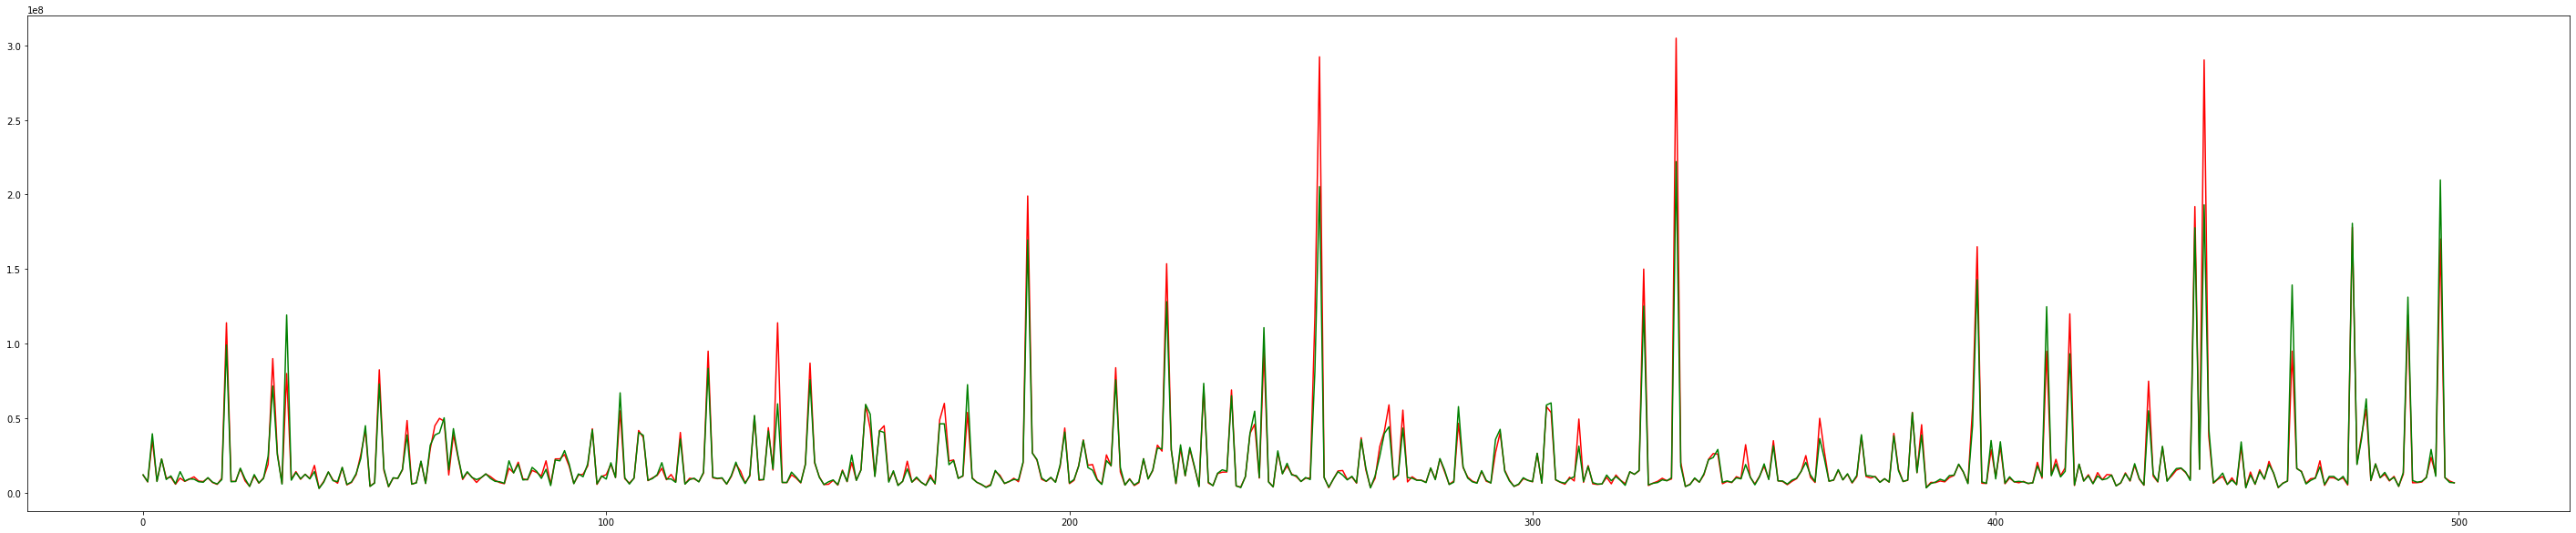

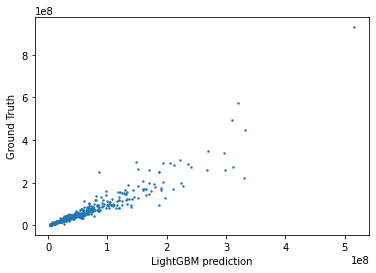

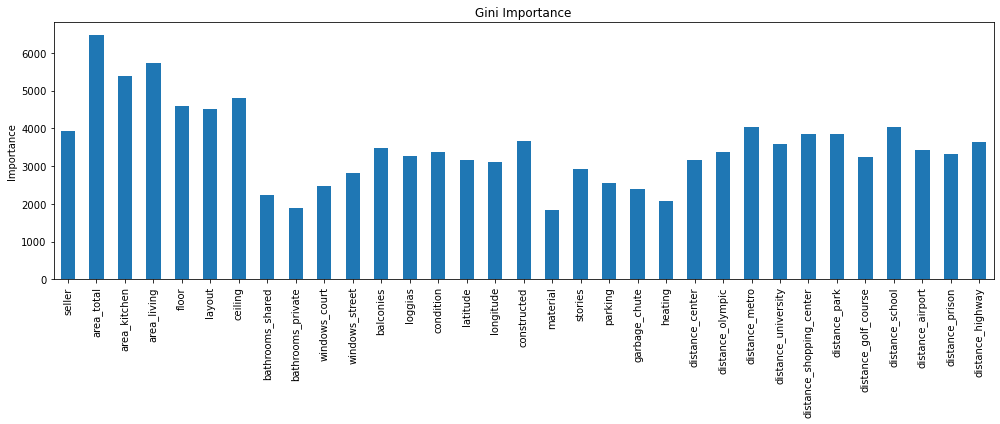

In [193]:
# normalize training data
train_data = dfTrain.copy()
train_data = process_data(train_data, keep_col=['price'], remove_col=['rooms', 'phones', 'new', 'elevator_without', 'elevator_passenger', 'elevator_service', 'district']) 

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.1, random_state=42)

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")

cols = X_train.columns

# log prices
y_train = np.log(y_train)

lgbm_regressor = lgb.LGBMRegressor(
    num_leaves=52,
    max_depth=75, 
    random_state=42,
    metric='rmse',
    n_jobs=4, 
    n_estimators=3640,
    colsample_bytree=0.48432530282059805,
    subsample=0.9272124012179532,
    learning_rate=0.05084923664278231
)

scaler = preprocessing.StandardScaler().fit(X_train)
imputor=IterativeImputer(
    estimator=BayesianRidge(),
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5)

X_train = imputor.fit_transform(X_train)
X_train = scaler.transform(X_train)

X_test = imputor.fit_transform(X_test)
X_test = scaler.transform(X_test)


lgbm_regressor.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_test, y_test)])

lgbm_prediction = lgbm_regressor.predict(X_test)
lgbm_prediction = np.exp(lgbm_prediction)

lgbm_rmsle = round(np.sqrt(mean_squared_log_error(lgbm_prediction, y_test)), 4)
print('Test RMSLE:', lgbm_rmsle)

# red is real prices, green is predicted prices
plt.figure(figsize=(50, 10))
plt.plot(y_test.values[:500], color = 'red')
plt.plot(lgbm_prediction[:500], color = 'green')
plt.show()

# correct predictions are on the diagonal
plt.scatter(lgbm_prediction, y_test, s=2)
plt.xlabel('LightGBM prediction')
plt.ylabel('Ground Truth')
plt.show()

importances = lgbm_regressor.feature_importances_
forest_importances = pd.Series(importances, index=cols)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# 0.154 
# 0.139 log
# 0.131 log + all_features + rmsle
# 0.131 log + all_features + rmse
# 0.132 log + all_features-(prison, airport)
# 0.132 log + all_features + keep_high_prices
# 0.129 -||- hyperparameter optimized
# 0.127 -||- hyperparameter optimized v2
# 0.111 0.03 test split
# 0.128 -||- 0.1 split, even more features
# 0.136 -||- only center

# 0.1290 all 
# 0.1258 remove=('rooms', 'phones', 'new', 'elevator_without', 'elevator_passenger', 'elevator_service')
# 0.1250 remove=('rooms', 'phones', 'new', 'elevator_without', 'elevator_passenger', 'elevator_service', 'district')

# 0.1256 added early stop
# 0.1252 without category type

# 0.1266 altered distance features+olympic
# 0.1261 reverted some alterations
# 0.1273


In [181]:
# normalize columns test data
test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'], remove_col=['rooms', 'phones', 'new', 'elevator_without', 'elevator_passenger', 'elevator_service', 'district', 'distance_olympic'])

# separate id from test data
ids = test_data.pop("id_x")

test_data = imputor.fit_transform(test_data)
test_data = scaler.transform(test_data)

# predict
lgbm_predictions = lgbm_regressor.predict(test_data)
lgbm_predictions = np.exp(lgbm_predictions)

# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] = lgbm_predictions
submission.to_csv("lgbm_predictions.csv", index=False)

C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# XGBoost

C:\Users\erikm\miniconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[02:17:53] WARNING: ..\src\learner.cc:541: 
Parameters: { enable_categorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:15.11842	validation_1-rmse:15.11412
[1]	validation_0-rmse:14.49055	validation_1-rmse:14.48682
[2]	validation_0-rmse:13.88879	validation_1-rmse:13.88571
[3]	validation_0-rmse:13.31188	validation_1-rmse:13.30920
[4]	validation_0-rmse:12.75901	validation_1-rmse:12.75710
[5]	validation_0-rmse:12.22921	validation_1-rmse:12.22803
[6]	validation_0-rmse:11.72138	validation_1-rmse:11.72088
[7]	validation_0-rmse:11.23462	validation_1-rmse:11.23443
[8]	validation_0-rmse:10.76825	validation_1-rmse:10.76822
[9]	validation_0-rmse:10.32116	validation_1-rmse:10.32141
[10]	validation_0-rmse:9.89259	validation_1-rmse:9.89319
[11]	validation_0-rmse:9.

C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[29]	validation_0-rmse:4.42458	validation_1-rmse:4.42870
[30]	validation_0-rmse:4.24145	validation_1-rmse:4.24564
[31]	validation_0-rmse:4.06596	validation_1-rmse:4.07040
[32]	validation_0-rmse:3.89768	validation_1-rmse:3.90244
[33]	validation_0-rmse:3.73650	validation_1-rmse:3.74129
[34]	validation_0-rmse:3.58199	validation_1-rmse:3.58714
[35]	validation_0-rmse:3.43396	validation_1-rmse:3.43931
[36]	validation_0-rmse:3.29199	validation_1-rmse:3.29739
[37]	validation_0-rmse:3.15601	validation_1-rmse:3.16158
[38]	validation_0-rmse:3.02568	validation_1-rmse:3.03135
[39]	validation_0-rmse:2.90076	validation_1-rmse:2.90650
[40]	validation_0-rmse:2.78109	validation_1-rmse:2.78681
[41]	validation_0-rmse:2.66646	validation_1-rmse:2.67237
[42]	validation_0-rmse:2.55648	validation_1-rmse:2.56268
[43]	validation_0-rmse:2.45126	validation_1-rmse:2.45745
[44]	validation_0-rmse:2.35037	validation_1-rmse:2.35644
[45]	validation_0-rmse:2.25362	validation_1-rmse:2.25977
[46]	validation_0-rmse:2.16100	

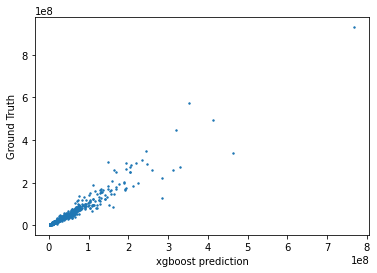

In [194]:
train_data = dfTrain.copy()
train_data = process_data(
    train_data, keep_col=['price'], 
    remove_col=['rooms', 'phones', 'elevator_without', 'elevator_passenger', 'elevator_service', 'district', 'distance_olympic'],
    do_category=True
)

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.1, random_state=42)

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")

# log prices
y_train = np.log(y_train)

cols = X_train.columns

scaler = preprocessing.StandardScaler().fit(X_train)

imputor=IterativeImputer(
    estimator=BayesianRidge(),
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5)

X_train = imputor.fit_transform(X_train)
X_train = scaler.transform(X_train)

X_test = imputor.fit_transform(X_test)
X_test = scaler.transform(X_test)

xgboost_regressor=xgboost.XGBRegressor(
    base_score=0.6809801659452004, booster='gbtree', colsample_bylevel=1,
    colsample_bynode=1, colsample_bytree=0.7880864100886343, enable_categorical=False,
    gamma=0, gpu_id=-1, importance_type=None,
    interaction_constraints='', learning_rate=0.04158422646007316, max_delta_step=0,
    max_depth=12, min_child_weight=7,
    monotone_constraints='()', n_estimators=1894, n_jobs=16,
    num_parallel_tree=1, predictor='auto', random_state=42, reg_alpha=0,
    reg_lambda=1, scale_pos_weight=1, subsample=0.8295598441506259, tree_method='exact',
    validate_parameters=1, verbosity=None, objective='reg:squarederror'
)

xgboost_regressor.fit(X_train, y_train, early_stopping_rounds=50, eval_set=[(X_train, y_train), (X_test, np.log(y_test))])

xgboost_prediction = xgboost_regressor.predict(X_test)
xgboost_prediction = np.exp(xgboost_prediction)

xgboost_rmsle = round(np.sqrt(mean_squared_log_error(xgboost_prediction, y_test)), 4)
print('Test RMSLE:', xgboost_rmsle)

# correct predictions are on the diagonal
plt.scatter(xgboost_prediction, y_test, s=2)
plt.xlabel('xgboost prediction')
plt.ylabel('Ground Truth')
plt.show()

# 0.144
# 0.138 log
# 0.130 -||- + all_features
# 0.130 -||- + rmse
# 0.123 -||- + optimized hyperparameters
# 0.112 -||- + 0.03 test split
# 0.126 -||- + 0.1 split, all features-center

# 0.1229 removed=('rooms', 'phones', 'new', 'elevator_without', 'elevator_passenger', 'elevator_service', 'district')
# 0.1213 removed=('rooms', 'phones', 'elevator_without', 'elevator_passenger', 'elevator_service', 'district')
# 0.1207 removed=('rooms', 'phones', 'elevator_without', 'elevator_passenger', 'elevator_service')

# 0.1211 added early stop
# 0.1208 altered distance features+olympic
# 0.1207 reverted some alterations
# 0.1221
# 

In [183]:
# normalize columns test data
test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'], remove_col=['rooms', 'phones', 'elevator_without', 'elevator_passenger', 'elevator_service', 'district', 'distance_olympic'], do_category=True)

# separate id from test data
ids = test_data.pop("id_x")

test_data = imputor.fit_transform(test_data)
test_data = scaler.transform(test_data)

# predict
xgboost_predictions = xgboost_regressor.predict(test_data)
xgboost_predictions = np.exp(xgboost_predictions)

# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] = xgboost_predictions
submission.to_csv("xgboost_predictions.csv", index=False)

C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


 # Catboost

C:\Users\erikm\miniconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Test RMSLE: 0.1227


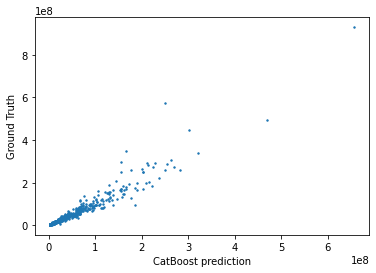

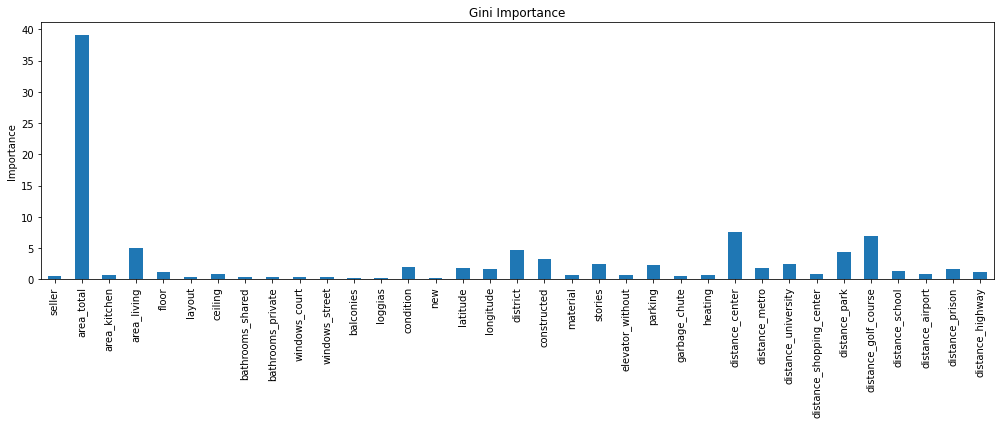

In [197]:
# normalize training data
train_data = dfTrain.copy()
train_data = process_data(train_data, keep_col=['price'], remove_col=['rooms', 'phones', 'elevator_passenger', 'elevator_service', 'distance_olympic'], do_category=True) 

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.1, random_state=42)

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")

cols = X_train.columns

# log prices
y_train = np.log(y_train)

scaler = preprocessing.StandardScaler().fit(X_train)
imputor=IterativeImputer(
    estimator=BayesianRidge(),
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5
)

X_train = imputor.fit_transform(X_train)
X_train = scaler.transform(X_train)

X_test = imputor.fit_transform(X_test)
X_test = scaler.transform(X_test)

catboost_regressor = CatBoostRegressor(
    n_estimators=2180,
    learning_rate=0.04364756663567214,
    thread_count=-1,
    depth=8,
    silent=True,
    random_state=42,
    bagging_temperature=0.16948019209038917
)

catboost_regressor.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=100) 

cat_boost_prediction = catboost_regressor.predict(X_test)
cat_boost_prediction = np.exp(cat_boost_prediction)

cat_boost_rmsle = round(np.sqrt(mean_squared_log_error(cat_boost_prediction, y_test)), 4)
print('Test RMSLE:', cat_boost_rmsle)

# correct predictions are on the diagonal
plt.scatter(cat_boost_prediction, y_test, s=2)
plt.xlabel('CatBoost prediction')
plt.ylabel('Ground Truth')
plt.show()

importances = catboost_regressor.feature_importances_
forest_importances = pd.Series(importances, index=cols)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# 0.170
# 0.142 log + all_features
# 0.132
# 0.130 -||- hyperparam
# 0.130 -||- hyperparam + early stop
# 0.111 0.03 test split
# 0.126 0.1 test split, early stop, alle priser
# 0.129 -||- -'layout', 'condition', 'rooms', 'phones', 'new'. 'material', 'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute

# 0.1258
# 0.1241 remove=('rooms', 'phones', 'new', 'elevator_without', 'elevator_passenger', 'elevator_service', 'district')
# 0.1232 remove=('rooms', 'phones', 'elevator_without', 'elevator_passenger', 'elevator_service')
# 0.1227 remove=('rooms', 'phones', 'elevator_passenger', 'elevator_service')

# 0.1261 altered distance features+olympic
# 0.1242 reverted some alterations
# 0.1223

In [185]:
# normalize columns test data
test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'], remove_col=['rooms', 'phones', 'elevator_passenger', 'elevator_service', 'distance_olympic'], do_category=True)

# separate id from test data
ids = test_data.pop("id_x")

test_data = imputor.fit_transform(test_data)
test_data = scaler.transform(test_data)

# predict
catboost_predictions = catboost_regressor.predict(test_data)
catboost_predictions = np.exp(catboost_predictions)

# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] = catboost_predictions
submission.to_csv("catboost_predictions.csv", index=False)

C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Stacking

In [186]:
acc = pd.DataFrame(
    {'LightGBM':     lgbm_rmsle,
     'XGBoost':      xgboost_rmsle,
     'CatBoost':     cat_boost_rmsle
    },
    index=[0]
)
acc = acc.T
acc.columns = ['MSE']
acc

,MSE
LightGBM,0.1252
XGBoost,0.1211
CatBoost,0.1227


# Simple averaging

Test MSE: 0.11822


Text(0, 0.5, 'Ground Truth')

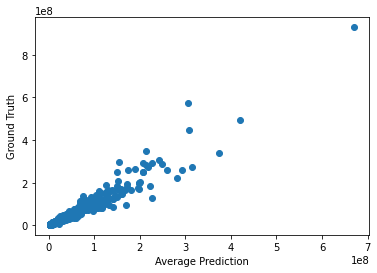

In [187]:
avg_prediction = np.average(
    [lgbm_prediction,
     xgboost_prediction,
     cat_boost_prediction
    ],
    weights = 1 / acc['MSE'] ** 10,
    axis=0
)

print('Test MSE:', round(np.sqrt(mean_squared_log_error(avg_prediction, y_test)), 5))

plt.scatter(avg_prediction, y_test)
plt.xlabel('Average Prediction')
plt.ylabel('Ground Truth')

# 0.123 alle features 0.1 split
# 0.122 -||- uten rf og ada

# remove dist   feature selection++ 
# 0.1278        0.1252              0.1266
# 0.1249        0.1211              0.1208
# 0.1258        0.1227              0.1261
#
# 0.122         0.11822             0.1188

In [188]:
avg_predictions = np.average(
    [lgbm_predictions,
     xgboost_predictions,
     catboost_predictions
    ],
    weights = 1 / acc['MSE'] ** 10,
    axis=0
)


In [189]:
# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] =  avg_predictions
submission.to_csv("average_predictions.csv", index=False)

# True Stacking

### First Step

In [127]:
train_data = dfTrain.copy()
train_data = process_data(train_data, keep_col=['price'])

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.1, random_state=42)

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")

scaler = preprocessing.StandardScaler().fit(X_train)
imputor=IterativeImputer(
    estimator=BayesianRidge(),
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5)


X_train = imputor.fit_transform(X_train)
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = imputor.fit_transform(X_test)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)

C:\Users\erikm\miniconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [67]:
# normalize columns test data
test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'])

# separate id from test data
ids = test_data.pop("id_x")

test_data = imputor.fit_transform(test_data)
test_data = scaler.transform(test_data)
test_data = pd.DataFrame(test_data)

C:\Users\erikm\miniconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [95]:
# for training
ntest = X_test.shape[0]

In [ ]:
# for submission
ntest = test_data.shape[0]

In [96]:
ntrain = X_train.shape[0]
SEED = 42 # for reproducibility
NFOLDS = 5 # set number of folds for out-of-fold prediction
kf = KFold(
    n_splits=NFOLDS,
    shuffle=True,
    random_state=SEED
) # K-Folds cross-validator

def get_oof(clf, x_train, y_train, x_test):
    """
    Popular function on Kaggle.
    
    Trains a classifier on 4/5 of the training data and
    predicts the rest (1/5). This procedure is repeated for all 5 folds,
    thus we have predictions for all training set. This prediction is one
    column of meta-data, later on used as a feature column by a meta-algorithm.
    We predict the test part and average predictions across all 5 models.
    
    Keyword arguments:
    clf -- classifier
    x_train -- 4/5 of training data
    y_train -- corresponding labels
    x_test -- all test data
    
    """
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [93]:
lgbm_regressor = lgb.LGBMRegressor(
    num_leaves=52,
    max_depth=75, 
    random_state=42,
    metric='rmse',
    n_jobs=4, 
    n_estimators=3640,
    colsample_bytree=0.48432530282059805,
    subsample=0.9272124012179532,
    learning_rate=0.05084923664278231
)

xgboost_regressor2=xgboost.XGBRegressor(
    base_score=0.6809801659452004, booster='gbtree', colsample_bylevel=1,
    colsample_bynode=1, colsample_bytree=0.7880864100886343, enable_categorical=False,
    gamma=0, gpu_id=-1, importance_type=None,
    interaction_constraints='', learning_rate=0.04158422646007316, max_delta_step=0,
    max_depth=12, min_child_weight=7,
    monotone_constraints='()', n_estimators=1894, n_jobs=16,
    num_parallel_tree=1, predictor='auto', random_state=42, reg_alpha=0,
    reg_lambda=1, scale_pos_weight=1, subsample=0.8295598441506259, tree_method='exact',
    validate_parameters=1, verbosity=None, objective='reg:squarederror'
)

catboost_regressor = CatBoostRegressor(
    n_estimators=2180,
    learning_rate=0.04364756663567214,
    thread_count=-1,
    depth=8,
    silent=True,
    random_state=42,
    bagging_temperature=0.16948019209038917
)

random_forest_regressor = RandomForestRegressor(
    n_estimators=333,
    max_depth=None,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=9732,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=42,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)

ada_boost_regressor = AdaBoostRegressor(
    n_estimators=650,
    learning_rate=0.05553081486523326,
    loss='square',
    random_state=42
)


In [91]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.ravel()
test_data = test_data.values

All predictions for train set: 20956
All predictions for test set: 9937


In [97]:
# for training
lgbm_oof_train, lgbm_oof_test = get_oof(lgbm_regressor, X_train, y_train, X_test)
xgb_oof_train, xgb_oof_test = get_oof(xgboost_regressor, X_train, y_train, X_test)
cat_oof_train, cat_oof_test = get_oof(catboost_regressor, X_train, y_train, X_test)
rf_oof_train, rf_oof_test = get_oof(random_forest_regressor, X_train, y_train, X_test)
ad_oof_train, ad_oof_test = get_oof(ada_boost_regressor, X_train, y_train, X_test)

[16:55:54] WARNING: ..\src\learner.cc:541: 
Parameters: { enable_categorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:56:10] WARNING: ..\src\learner.cc:541: 
Parameters: { enable_categorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:56:26] WARNING: ..\src\learner.cc:541: 
Parameters: { enable_categorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find a

In [ ]:
# for submission
lgbm_oof_train, lgbm_oof_test = get_oof(lgbm_regressor, X_train, y_train, test_data)
xgb_oof_train, xgb_oof_test = get_oof(xgboost_regressor, X_train, y_train, test_data)
cat_oof_train, cat_oof_test = get_oof(catboost_regressor, X_train, y_train, test_data)

### Second Step

In [98]:
x_train = np.concatenate((
    lgbm_oof_train,
    xgb_oof_train,
    cat_oof_train
), axis=1)

x_test = np.concatenate((
    lgbm_oof_test,
    xgb_oof_test,
    cat_oof_test
), axis=1)

In [110]:
META_MODEL = lgb.LGBMRegressor(
    num_leaves=79,
    max_depth=8, 
    random_state=SEED, 
    silent=True, 
    metric='rmse',
    n_jobs=4, 
    n_estimators=1732,
    colsample_bytree=0.9964574426846338,
    subsample=0.9044838201779967,
    learning_rate=0.023921173830270648
)

META_MODEL.fit(x_train, y_train)

LGBMRegressor(colsample_bytree=0.9964574426846338,
              learning_rate=0.023921173830270648, max_depth=8, metric='rmse',
              n_estimators=1732, n_jobs=4, num_leaves=79, random_state=42,
              subsample=0.9044838201779967)

Test MSE: 0.14


Text(0, 0.5, 'Ground Truth')

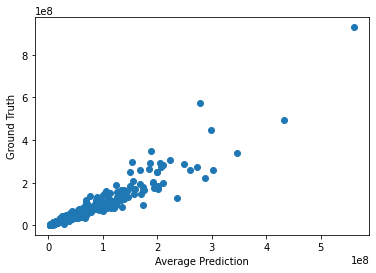

In [111]:
final_predictions = META_MODEL.predict(x_test)

print('Test MSE:', round(np.sqrt(mean_squared_log_error(final_predictions, y_test)), 3))

plt.scatter(avg_prediction, y_test)
plt.xlabel('Average Prediction')
plt.ylabel('Ground Truth')

In [67]:
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] =  final_predictions
submission.to_csv("final_predictions.csv", index=False)